In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from ipywidgets import interact, widgets
#from IPython.display import display
import scipy.linalg
import itertools
import scipy.misc as sc
#from IPython.core.display import displa/y, HTML
#display(HTML("<style>.container { width:95% !important; }</style>"))
from IPython import display
import pylab as pl
import time
from scipy import signal
from scipy import io
from skimage import transform
#import cupy as cp
import hdf5storage
import pywt
import copy
import math
# import tensorflow as tf
# import tensorflow.keras as keras
# from tensorflow.keras import backend as K
# from tensorflow.keras import layers
# from tensorflow.keras.callbacks import ModelCheckpoint
import os
import cv2
from os import path
import imageio

ModuleNotFoundError: No module named 'ipywidgets'

# Forward model code

In [2]:
def pad2d (x):
    Ny=np.shape(x)[0]
    Nx=np.shape(x)[1]
    return np.pad(x,((Ny//2,Ny//2),(Nx//2,Nx//2)),'constant', constant_values=(0))

def pad4d(x):
    Ny=np.shape(x)[0]
    Nx=np.shape(x)[1]
    return np.pad(x,((Ny//2,Ny//2),(Nx//2,Nx//2),(0,0),(0,0)),'constant', constant_values=(0))

def crop4d(x,rcL,rcU,ccL,ccU):
    return x[rcL:rcU,ccL:ccU,:,:]

def crop2d(x,rcL,rcU,ccL,ccU):   
    return x[rcL:rcU,ccL:ccU]

def nocrop(x):
    return x

def nopad(x):
    return x

def A_2d_svd(x,H,weights,pad,mode='shift_variant'): #NOTE, H is already padded outside to save memory
    x=pad(x)
    Y=np.zeros((np.shape(x)[0],np.shape(x)[1]))
        
    if (mode =='shift_variant'):
        for r in range (0,np.shape(weights)[2]):
            X=np.fft.fft2((np.multiply(pad(weights[:,:,r]),x)))
            Y=Y+ np.multiply(X,H[:,:,r])
    
    return np.real((np.fft.ifftshift(np.fft.ifft2(Y))))

def A_2d(x,psf,pad):
    X=np.fft.fft2((pad(x)))
    H=np.fft.fft2((pad(psf)))
    Y=np.multiply(X,H)
    
    return np.real((np.fft.ifftshift(np.fft.ifft2(Y))))

def A_2d_adj_svd(Hconj,weights,y,pad):
    y=pad(y)
    x=np.zeros((np.shape(y)[0],np.shape(y)[1]))
    for r in range (0, np.shape(weights)[2]):
        x=x+np.multiply(pad(weights[:,:,r]),(np.real(np.fft.ifftshift(np.fft.ifft2(np.multiply(Hconj[:,:,r], np.fft.fft2((y))))))))
    #note the weights are real so we dont take the complex conjugate of it, which is the adjoint of the diag 
    return x

def A_2d_adj(y,psf,pad):
    H=np.fft.fft2((pad(psf)))
    Hconj=np.conj(H)
    x=(np.real(np.fft.ifftshift(np.fft.ifft2(np.multiply(Hconj, np.fft.fft2((pad(y))))))))
    
    return x

def A_3d(x,h,pad):
    #h is the psf stack
    #x is the variable to convolve with h
    x=pad(x)
    B=np.zeros((np.shape(x)[0],np.shape(x)[1]))
        

    for z in range (0,np.shape(h)[2]):
        #X=np.fft.fft2((np.multiply(pad(weights[:,:,z]),x)))
        B=B+ np.multiply(np.fft.fft2(x[:,:,z]),np.fft.fft2(pad(h[:,:,z])))
    
    return np.real((np.fft.ifftshift(np.fft.ifft2(B))))


def A_3d_svd(v,alpha,H,pad):
    #alpha is Ny-Nx-Nz-Nr, weights
    #v is Ny-Nx-Nz
    #H is Ny-Nx-Nz-Nr
    # b= sum_r (sum_z (h**alpra.*v))
    b=np.zeros((np.shape(v)[0],np.shape(v)[1]))
    for r in range (np.shape(H)[3]):
        for z in range (np.shape(H)[2]):
            b=b+np.multiply(H[:,:,z,r],np.fft.fft2(np.multiply(v[:,:,z],alpha[:,:,z,r])))
    
    return np.real(np.fft.ifftshift(np.fft.ifft2(b)))

def A_3d_adj(x,h,pad):
    y=np.zeros(np.shape(h))
    X=np.fft.fft2(pad(x))
    for z in range(np.shape(h)[2]):
        H=np.conj(np.fft.fft2(pad(h[:,:,z])))
        y[:,:,z]=np.real(np.fft.ifftshift(np.fft.ifft2(np.multiply(H,X))))
    return y

def A_3d_adj_svd(b,alpha,Hconj,pad):
    #y=sum_r(alpha.*H_conj**b)
    y=np.zeros((np.shape(alpha)[0],np.shape(alpha)[1],np.shape(alpha)[2]))
    B=np.fft.fft2(pad(b))
    for z in range(np.shape(alpha)[2]):
        for r in range(np.shape(alpha)[3]):
            y[:,:,z]=y[:,:,z]+np.multiply(alpha[:,:,z,r],np.fft.ifftshift(np.fft.ifft2(np.multiply(B,Hconj[:,:,z,r]))))
        
    return y

def grad(v):
    return np.array(np.gradient(v))  #returns gradient in x and in y


def grad_adj(v):  #adj of gradient is negative divergence
    z = np.zeros((n,n)) + 1j
    z -= np.gradient(v[0,:,:])[0]
    z -= np.gradient(v[1,:,:])[1]
    return z



# Wiener Deconvolution

# Generate Train and Test data

In [3]:
#normalize original data and convert to gray scale.Note: need to crop before training and testing

DATADIR= 'C:/Research/Data/Target_orig'
mu=0
sigma=np.random.rand(len(os.listdir(DATADIR)))*0.04+0.01 #abit much maybe 0.04 best
PEAK=np.random.rand(len(os.listdir(DATADIR)))*1000+50

for i in range (len(os.listdir(DATADIR))):
    img =os.listdir(DATADIR)[i]
    I=cv2.imread(path.join(DATADIR,img))
    I = cv2.cvtColor(I, cv2.COLOR_BGR2GRAY)
    I=cv2.resize(I,( 648,486))

    I=I/np.max(I)
    #I[I<0.12]=0
    sim=crop2d(A_2d_svd(I,H,weights,pad2d),rcL,rcU,ccL,ccU)
    sim=sim/np.max(sim)
    sim=np.maximum(sim,0)

    p_noise = np.random.poisson(sim * PEAK[i])/PEAK[i]
    
    g_noise= np.random.normal(mu, sigma[i], 648*486)
    g_noise=np.reshape(g_noise,(486,648))
    sim=sim+g_noise+p_noise
    sim=sim/np.max(sim)
    sim=np.maximum(sim,0)
    sim=np.uint8(sim*255)
    sim=sim[18:466,4:644]

    imageio.imwrite('C:/Research/Data/Train/'+str(i)+'.png', sim) 
    
    I=np.uint8(I*255)
    I=I[18:466,4:644]
    
    imageio.imwrite('C:/Research/Data/Target/'+str(i)+'.png', I) 
    
       


NameError: name 'os' is not defined

# Setup Tensorflow model

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
batch_size = 1
DATADIR= 'C:/Research/Data/Target'
img_height = 448
img_width = 640

In [5]:
target_dir=[]
input_dir=[]
target_path=[]
input_path=[]
for i in range(len(os.listdir(DATADIR))):
    target_dir.append('C:/Research/Data/Target/')
    input_dir.append('C:/Research/Data/Train/')
target_img=os.listdir(target_dir[0])
input_img=os.listdir(input_dir[0])
for i in range (len(os.listdir(DATADIR))):
    target_path.append(target_dir[i]+target_img[i])
    input_path.append(input_dir[i]+input_img[i])

In [6]:
# Create a first dataset of file paths and labels
dataset = tf.data.Dataset.from_tensor_slices((input_path, target_path))

In [7]:
def parse_function(inputname, outputname):

    # Read an image from a file
    input_string = tf.io.read_file(inputname)
    # Decode it into a dense vector
    input_decoded = tf.image.decode_png(input_string, channels=1)
    # Resize it to fixed shape
    input_resized = tf.image.resize(input_decoded, [img_height, img_width])
    # Normalize it from [0, 255] to [0.0, 1.0]
    input_normalized = input_resized / 255.0
    

    
    # Read an image from a file
    output_string = tf.io.read_file(outputname)
    # Decode it into a dense vector
    output_decoded = tf.image.decode_png(output_string, channels=1)
    # Resize it to fixed shape
    output_resized = tf.image.resize(output_decoded, [img_height, img_width])
    # Normalize it from [0, 255] to [0.0, 1.0]
    output_normalized = output_resized / 255.0
    
    return input_normalized, output_normalized

In [8]:
image_count=len(os.listdir(DATADIR))
print(image_count)

2254


In [9]:
dataset = dataset.shuffle(image_count, reshuffle_each_iteration=False)

In [10]:
val_size = int(image_count * 0.1)
train_ds = dataset.skip(val_size)
val_ds = dataset.take(val_size)
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2029
225


In [11]:
train_ds = train_ds.map(parse_function, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(parse_function, num_parallel_calls=AUTOTUNE)

In [12]:
def configure_for_performance(ds):  #shuffte, batch, and have batches available asap
    ds = ds.cache()
    ds = ds.shuffle(buffer_size=1000)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

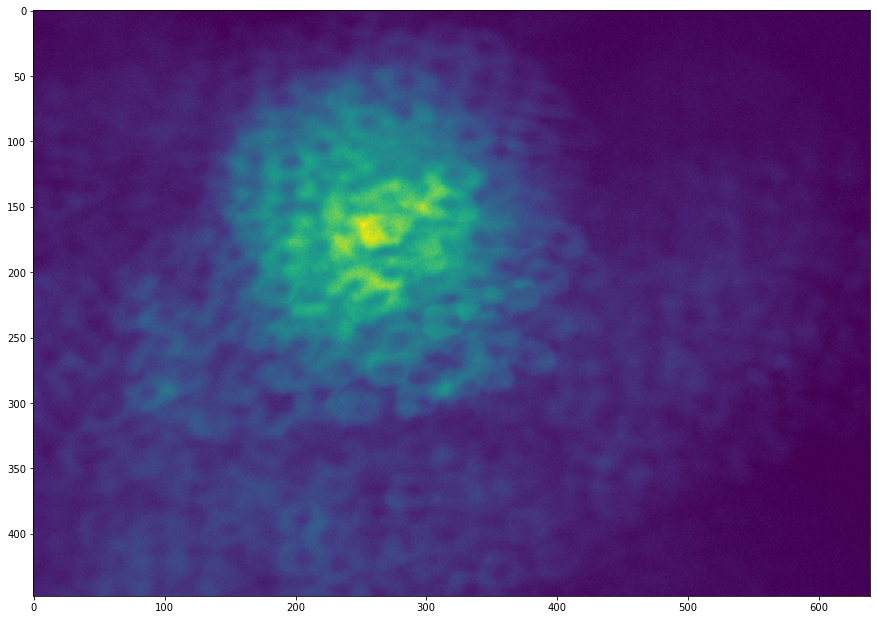

In [13]:
#visualzie data to make sure all is good
input_batch, target_batch = next(iter(train_ds))
plt.figure(figsize=(15,15))
plt.imshow(input_batch[0,:,:,0])

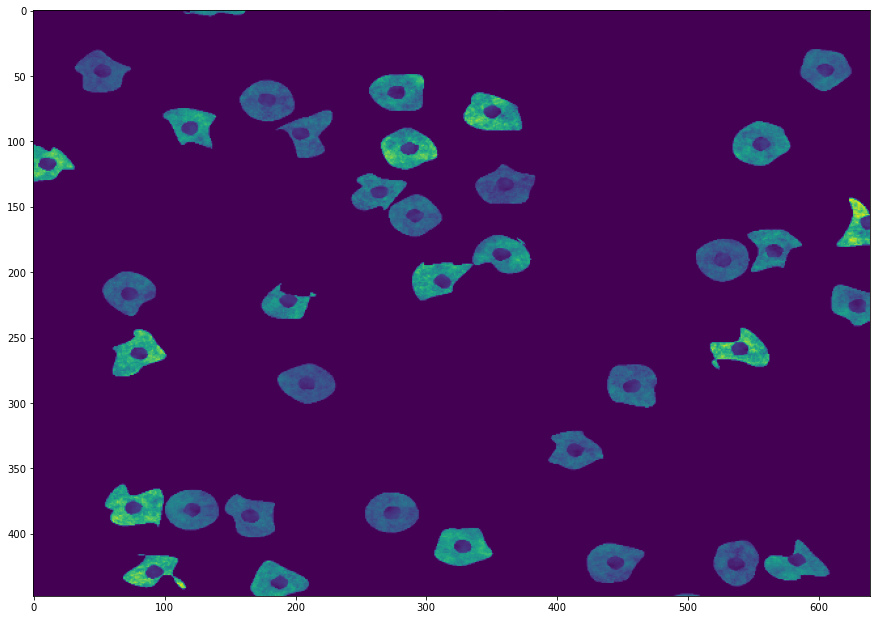

In [14]:
plt.figure(figsize=(15,15))
plt.imshow(target_batch[0,:,:,0])

## Load Data

In [7]:
## rank 12, z downsample by 4 (x,y,r,z)
h=scipy.io.loadmat('C:\Research\RandoscopePSFS\\SVD_2_5um_PSF_5um_1_ds4_dsz1_comps_green_SubAvg.mat') 
weights=scipy.io.loadmat('C:\Research\RandoscopePSFS\\SVD_2_5um_PSF_5um_1_ds4_dsz1_weights_green_SubAvg.mat')

In [8]:
# Back ground subtracted data
restarget=hdf5storage.loadmat('C:\Research\RandoscopePSFS\\res_15_z30.mat') 
restarget=restarget['res_15_z30']
restarget=restarget/np.max(restarget)
res_target=np.maximum(restarget,0)


Text(0.5, 1.0, 'Raw Data')

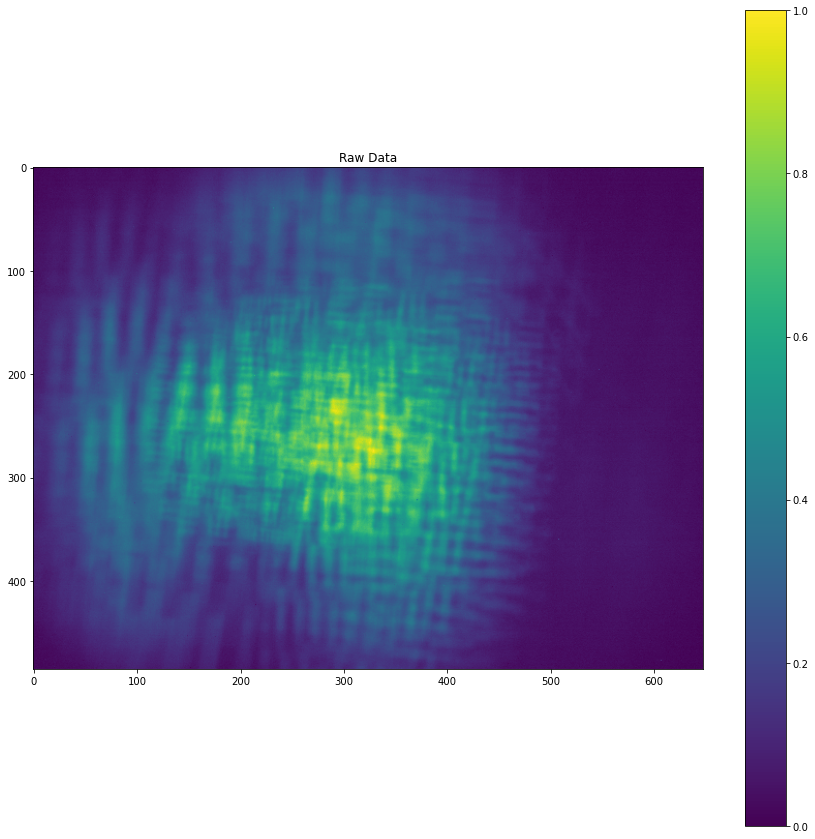

In [9]:
plt.figure(figsize=(15,15))
plt.imshow(res_target)
plt.colorbar()
plt.title('Raw Data')

Text(0.5, 1.0, 'Fista Recon')

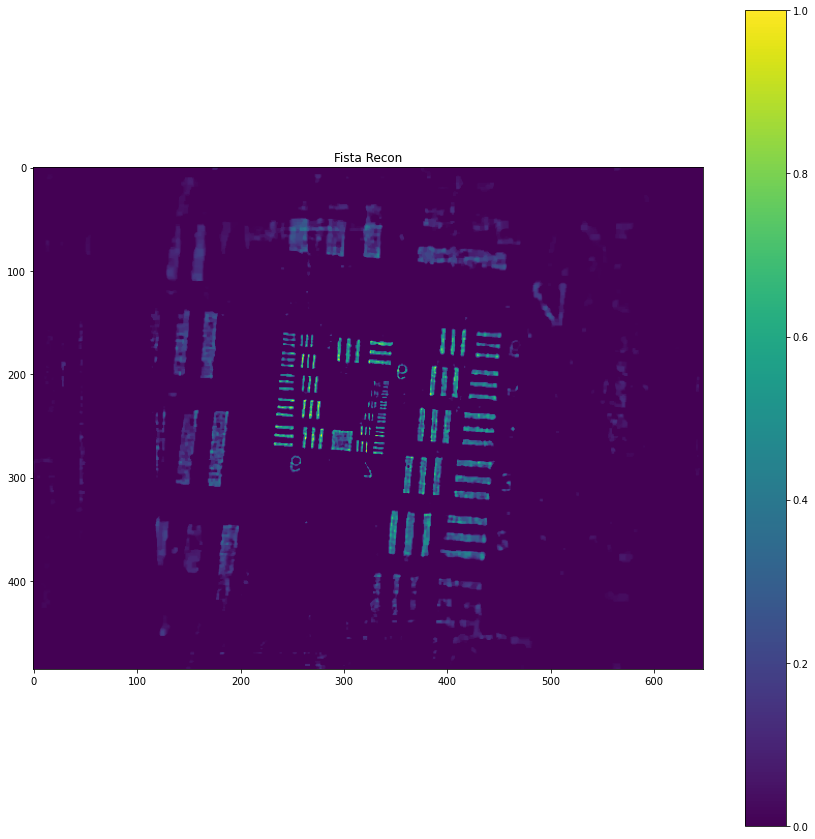

In [10]:
xtrue=plt.imread('C:\Research\RandoscopePSFS\\resTarget_2_MMStack_Img_15_000_000.ome_Z_030_T_001_res_target_paper.png')
plt.figure(figsize=(15,15))
plt.imshow(xtrue)
plt.colorbar()
plt.title('Fista Recon')

In [11]:
depth_plane=30

h=h['array_out']
weights=weights['array_out']
# make sure its (x,y,z,r)
h=np.swapaxes(h,2,3)
weights=np.swapaxes(weights,2,3)

h=h[:,:,depth_plane,:]
weights=weights[:,:,depth_plane,:]

# Normalize weights to have maximum sum through rank of 1
weights_norm = np.max(np.sum(weights[np.shape(weights)[0]//2-1,np.shape(weights)[1]//2-1,:],0))
weights = weights/weights_norm;

#normalize by norm of all stack. Can also try normalizing by max of all stack or by norm of each slice
h=h/np.linalg.norm(np.ravel(h))

Text(0.5, 1.0, 'PSF Z = 29')

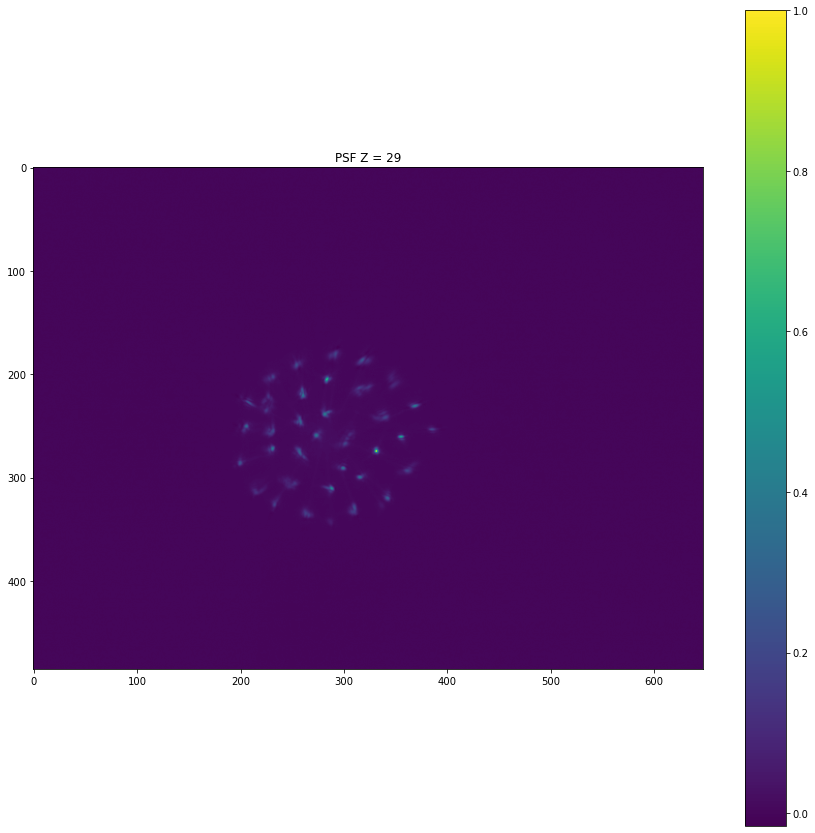

In [12]:
psf=np.zeros((np.shape(weights)[0],np.shape(weights)[1]))
for r in range (0,np.shape(weights)[2]):
    psf=psf+np.multiply(h[:,:,r],weights[:,:,r])
psf=psf/np.max(psf)
plt.figure(figsize=(15,15))
plt.imshow(psf)
plt.colorbar()
plt.title('PSF Z = 29')

In [14]:
# padded values for 2D

ccL = np.shape(h)[1]//2
ccU = 3*np.shape(h)[1]//2
rcL = np.shape(h)[0]//2
rcU = 3*np.shape(h)[0]//2

H=np.ndarray((np.shape(h)[0]*2,np.shape(h)[1]*2,np.shape(h)[2]), dtype=complex)
Hconj=np.ndarray((np.shape(h)[0]*2,np.shape(h)[1]*2,np.shape(h)[2]),dtype=complex)
for i in range (np.shape(h)[2]):
    H[:,:,i]=(np.fft.fft2(pad2d(h[:,:,i])))
    Hconj[:,:,i]=(np.conj(H[:,:,i]))



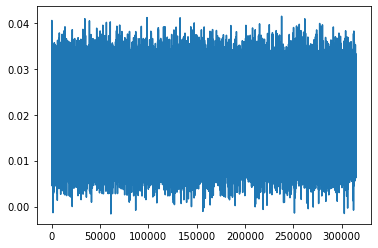

In [15]:
## Generate noise
mu=0.02 #noise mean
std=0.005  #noise std

noise=np.reshape(np.random.normal(mu,std,np.shape(xtrue)[0]*np.shape(xtrue)[1]),(np.shape(xtrue)[0],np.shape(xtrue)[1]))
plt.plot(np.ravel(noise))

2.344178655377803
-0.05818584381079448


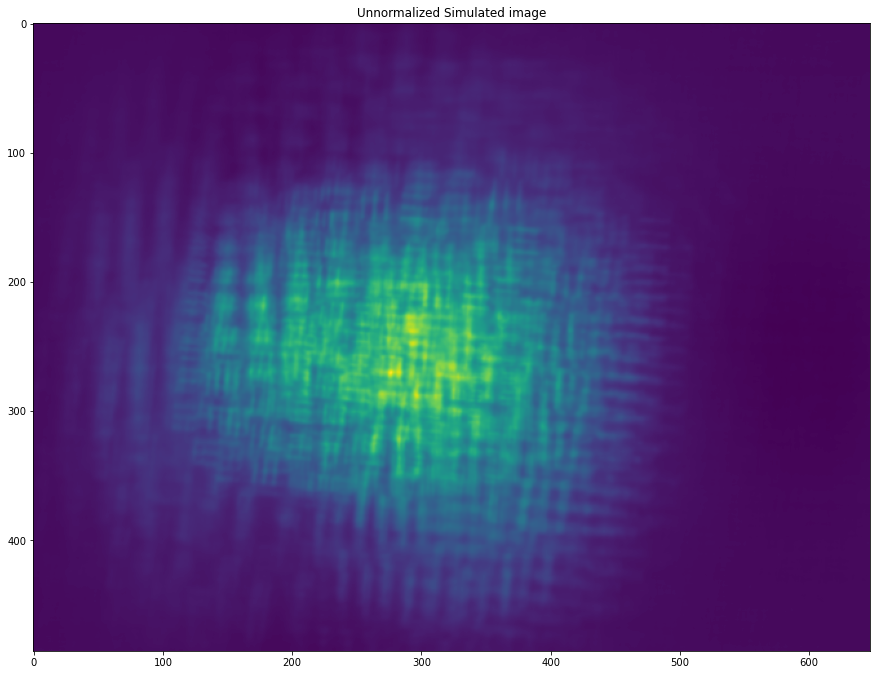

In [16]:
sim=crop2d(A_2d_svd(xtrue,H,weights,pad2d),rcL,rcU,ccL,ccU)
plt.figure(figsize=(15,15))
plt.imshow(sim)
plt.title('Unnormalized Simulated image')
print(np.max(sim))
print(np.min(sim))

# Wiener deconvolution

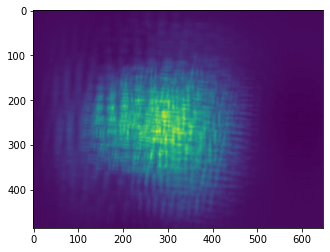

In [19]:
xtrue=plt.imread('C:\Research\RandoscopePSFS\\resTarget_2_MMStack_Img_15_000_000.ome_Z_030_T_001_res_target_paper.png')
x2d=xtrue

# simulate a 2D res target data at depth 29
y2d=crop2d(A_2d_svd(x2d,H,weights,pad2d),rcL,rcU,ccL,ccU)

y2d=y2d/np.max(y2d)

plt.imshow(y2d)


In [28]:
Ah_b_2d=crop2d(A_2d_adj_svd(Hconj,weights,y2d,pad2d),rcL,rcU,ccL,ccU)

def A2d_inv_cg(x, alpha_cg):
    test=crop2d(A_2d_adj_svd(Hconj,weights,crop2d(A_2d_svd(x,H,weights,pad2d),rcL,rcU,ccL,ccU),pad2d),rcL,rcU,ccL,ccU)+alpha_cg*x
    
    return test
def cgsolve(z,b,Niter, alpha_cg):
    #b is A*y
    #solving z=M-1b
    
    
    
    r=b-A2d_inv_cg(z, alpha_cg)
    p=r.copy()
    rsold=np.conj(r.ravel()).dot(r.ravel())
    print('loss ', rsold)
    for i in range(0,Niter):
        Ap=A2d_inv_cg(p, alpha_cg)
        alpha=rsold/(np.conj(p.ravel()).dot(Ap.ravel()))
        z=z+alpha*p
        r=r-alpha*Ap
        
        rsnew=np.conj(r.ravel()).dot(r.ravel())
        if np.sqrt(rsnew)<1e-10:
            break
            
        p=r+(rsnew/rsold)*p
        rsold=rsnew
        print('loss ',rsold)
    return z

In [33]:
Niter=20
z_wiener=np.zeros(np.shape(x2d))
x_wiener=cgsolve(z_wiener,Ah_b_2d,Niter, 1e-4)

loss  7661267.271402946
loss  73918.63059830351
loss  18148.587964334383
loss  2811.7081983969765
loss  5890.082269489717
loss  1106.4968716429478
loss  1164.2836397958765
loss  432.2547476931676
loss  309.3533442708844
loss  357.75748272722086
loss  138.48921042433008
loss  79.4638890514444
loss  68.73653951090076
loss  621.4650593731595
loss  40.680646186454524
loss  28.49712538767767
loss  18.03477834128801
loss  17.7955758843264
loss  11.212566652843131
loss  8.600709559041414
loss  21.347449791967822


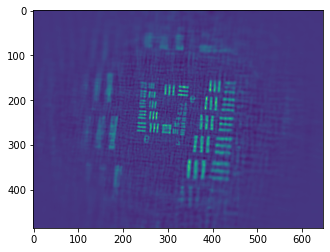

In [35]:
plt.imshow(x_wiener)

In [13]:
sim=sim/np.max(sim)
sim=np.maximum(sim,0)
plt.imshow(y-sim)
plt.colorbar()

NameError: name 'y' is not defined

In [ ]:
# resize images
xtrue=xtrue[18:466,4:644]
sim=sim[18:466,4:644]

In [29]:
res_target=res_target[18:466,4:644]

## Unet

In [15]:
class Dense(layers.Layer):
    # Dense
    
    def __init__(self, out_channels):
        super(Dense, self).__init__()
        self.dense = layers.Dense(out_channels,use_bias=False)

        
    def call(self, x):
        x = self.dense(x)

        return x



class DenseLRelu(layers.Layer):
    # Dense then leaky Relu
    
    def __init__(self, out_channels):
        super(DenseLRelu, self).__init__()
        self.dense = layers.Dense(out_channels,use_bias=False)
        self.lrelu = layers.LeakyReLU()
        
    def call(self, x):
        x = self.dense(x)

        x = self.lrelu(x)
        return x

class ConvLRelu(layers.Layer):
    # Convolutional  -> LeakyReLU
    
    def __init__(self, out_channels, kernel_size=(3, 3), padding='same'):
        super(ConvLRelu, self).__init__()
        self.conv = layers.Conv2D( out_channels, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),use_bias=False,padding='same', strides=1)
        self.lrelu = layers.LeakyReLU()
        
    def call(self, x):
        x = self.conv(x)
        x = self.lrelu(x)
        return x    
    
    
class resnet(layers.Layer):
    # Convolutional  -> LeakyReLU
    
    def __init__(self, out_channels, kernel_size=(3, 3), padding='same'):
        super(resnet, self).__init__()
        self.conv1 = layers.Conv2D( out_channels, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),use_bias=False,padding='same', strides=1)
        self.lrelu1 = layers.LeakyReLU()
        self.conv2 = layers.Conv2D( out_channels, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),use_bias=False,padding='same', strides=1)
        self.lrelu2 = layers.LeakyReLU()
        
        
    def call(self, x):
        orig=x
        x = self.conv1(x)
        x = self.lrelu1(x)
        x = self.conv2(x)
        x = self.lrelu2(x)
        x=x+orig
        return x    

In [16]:
# class one_Unet(tf.keras.Model):
#     # Upsample (2x) -> concatenation -> ConvBnRelu -> ConvBnRelu -> ConvBnRelu

#     def __init__(self,drop_ratio, training=False, size=512):
        
#         super(one_Unet, self).__init__()
        
#         self.drop_ratio=drop_ratio #NOTES MADE UP
        
#         ## layers!!
        
#         self.conv2dLRelu=ConvLRelu(32)
        
#         #self.leakyrelu3=layers.LeakyReLU()

#         self.conv2d2=layers.Conv2D( 1, 3, kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same',strides=1, 
#                                                  )
        
        

        
        
#         self.encoder_conv1=[]
#         self.encoder_lrelu1=[]
#         self.encoder_conv2=[]
#         self.encoder_lrelu2=[]
#         self.encoder_pool=[]

#         for i, k in enumerate([48, 64, 64, 80, 80, 96]):
            
            
#             if i==1:
#                 self.encoder_conv1.append(layers.Conv2D(k, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same',strides=1))
#                 self.encoder_lrelu1.append(layers.LeakyReLU())
#                 self.encoder_conv2.append(layers.Conv2D(k, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same',strides=1))
#                 self.encoder_lrelu2.append(layers.LeakyReLU())
#                 self.encoder_pool.append(layers.MaxPool2D(pool_size=2, strides=2))
#             else:
#                 self.encoder_conv1.append(layers.Conv2D(k, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same',strides=1))
#                 self.encoder_lrelu1.append(layers.LeakyReLU())
#                 self.encoder_conv2.append(layers.Conv2D(k, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same',strides=1))
#                 self.encoder_lrelu2.append(layers.LeakyReLU())
#                 self.encoder_pool.append(layers.MaxPool2D(pool_size=2, strides=2))

            
        
#         self.bottleneck_conv=[]
#         self.bottleneck_lrelu=[]
#         for j in range(4): #bottleneck layer doesnt seem to be resnet
#             self.bottleneck_conv.append(layers.Conv2D(32, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same', strides=1))
#             self.bottleneck_lrelu.append(layers.LeakyReLU())
            
            
#         self.decoder_conv1=[]
#         for i, k in enumerate([96, 80, 80, 64, 64]): #decoder
#             self.decoder_conv1.append(layers.Conv2DTranspose(k, 3,padding='same', strides=2))
            
#         self.conv2dtranspose=layers.Conv2DTranspose(48, 3, padding='same',strides=2)

        
#     def call(self, resized_images):
        
#         self.semi_global_features=resized_images
#         for i_unet in range(1):
#             self.enc = []
#             for i, k in enumerate([48, 64, 64, 80, 80, 96]): #encoder
                
#                 if i_unet==0:
#                     self.semi_global_features = self.encoder_conv1[i](self.semi_global_features)
#                     self.semi_global_features=self.encoder_lrelu1[i](self.semi_global_features)
#                     self.semi_global_features = self.encoder_conv2[i](self.semi_global_features)
#                     self.semi_global_features=self.encoder_lrelu2[i](self.semi_global_features)
#                     self.semi_global_features=self.encoder_pool[i](self.semi_global_features)

                    
#                 elif i_unet==1:
#                     self.semi_global_features = self.encoder_conv2[i](self.semi_global_features)
#                     self.semi_global_features=self.encoder_lrelu2[i](self.semi_global_features)
                    
#                 elif i_unet==2:
#                     self.semi_global_features = self.encoder_conv3[i](self.semi_global_features)
#                     self.semi_global_features=self.encoder_lrelu3[i](self.semi_global_features)
                    
#                 elif i_unet==3:
#                     self.semi_global_features = self.encoder_conv4[i](self.semi_global_features)
#                     self.semi_global_features=self.encoder_lrelu4[i](self.semi_global_features)                
                
#                 self.enc.append(self.semi_global_features)
#             self.enc = self.enc[:-1]
#             #self.bottleneck_properties = tf.tile(normalized_properties,[1,8,8,1])
            


            
#             #self.semi_global_features = tf.concat([self.semi_global_features, self.bottleneck_properties], axis=-1)
#             self.semi_global_features = self.conv2dLRelu(self.semi_global_features)
            


#             self.x = self.semi_global_features
            
            
#             for j in range(4): #bottleneck layer doesnt seem to be resnet
#                 self.semi_global_features = self.bottleneck_conv[j](self.semi_global_features)
#                 self.semi_global_features= self.bottleneck_lrelu[j](self.semi_global_features)
#                 self.semi_global_features = self.semi_global_features + self.x
#                 #self.x = self.semi_global_features

#             for i, k in enumerate([96, 80, 80, 64, 64]): #decoder
                
#                 if i_unet==0:
#                     self.semi_global_features = self.decoder_conv1[i](self.semi_global_features)
#                 elif i_unet==1:
#                     self.semi_global_features = self.decoder_conv2[i](self.semi_global_features)
                    
#                 elif i_unet==2:
#                     self.semi_global_features = self.decoder_conv3[i](self.semi_global_features)
#                 elif i_unet==3:
#                     self.semi_global_features = self.decoder_conv4[i](self.semi_global_features)
                
#                 self.semi_global_features = tf.concat([self.semi_global_features, self.enc[-1]], axis=-1)
#                 self.enc = self.enc[:-1]
                
            
#             self.semi_global_features = self.conv2dtranspose(self.semi_global_features)
#             self.semi_global_features = tf.nn.dropout(self.semi_global_features,
#                                                      rate=self.drop_ratio)
            
#             if i_unet == 0:
#                 self.features_level0 = self.semi_global_features
#             elif i_unet == 1:
#                 self.features_level1 = tf.concat([self.semi_global_features, self.features_level0], axis=-1)
#             elif i_unet == 2:
#                 self.features_level2 = tf.concat([self.semi_global_features, self.features_level1], axis=-1)
#             else:
#                 self.features_level3 = tf.concat([self.semi_global_features, self.features_level2], axis=-1)
        
#         self.predictions_resized_level0 = self.conv2d2(self.features_level0)
        
       
#         return self.predictions_resized_level0



In [17]:
class two_Unet(tf.keras.Model):
    # Upsample (2x) -> concatenation -> ConvBnRelu -> ConvBnRelu -> ConvBnRelu

    def __init__(self,drop_ratio, training=False, size=512):
        
        super(two_Unet, self).__init__()
        
        self.drop_ratio=drop_ratio #NOTES MADE UP
        
        ## layers!!
        
        
        #self.leakyrelu3=layers.LeakyReLU()

        self.conv2d2=layers.Conv2D( 1, 1, kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same',strides=1, 
                                                 )
        self.conv2d3=layers.Conv2D( 1, 1, kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same',strides=1, 
                                                 )
        
        

        
        
        self.encoder_conv1=[]
        self.encoder_lrelu1=[]
        self.encoder_conv2=[]
        self.encoder_lrelu2=[]
        self.encoder_pool=[]

        for i, k in enumerate([64, 128, 256, 512]):
            
            
            if i==1:
                self.encoder_conv1.append(layers.Conv2D(k, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same',strides=1))
                self.encoder_lrelu1.append(layers.LeakyReLU())
                self.encoder_conv2.append(layers.Conv2D(k, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same',strides=1))
                self.encoder_lrelu2.append(layers.LeakyReLU())
                self.encoder_pool.append(layers.MaxPool2D(pool_size=2, strides=2))
            else:
                self.encoder_conv1.append(layers.Conv2D(k, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same',strides=1))
                self.encoder_lrelu1.append(layers.LeakyReLU())
                self.encoder_conv2.append(layers.Conv2D(k, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same',strides=1))
                self.encoder_lrelu2.append(layers.LeakyReLU())
                self.encoder_pool.append(layers.MaxPool2D(pool_size=2, strides=2))

        self.encoder2_conv1=[]
        self.encoder2_lrelu1=[]
        self.encoder2_conv2=[]
        self.encoder2_lrelu2=[]
        self.encoder2_pool=[]

        for i, k in enumerate([64, 128, 256, 512]):
            
            
            if i==1:
                self.encoder2_conv1.append(layers.Conv2D(k, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same',strides=1))
                self.encoder2_lrelu1.append(layers.LeakyReLU())
                self.encoder2_conv2.append(layers.Conv2D(k, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same',strides=1))
                self.encoder2_lrelu2.append(layers.LeakyReLU())
                self.encoder2_pool.append(layers.MaxPool2D(pool_size=2, strides=2))
            else:
                self.encoder2_conv1.append(layers.Conv2D(k, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same',strides=1))
                self.encoder2_lrelu1.append(layers.LeakyReLU())
                self.encoder2_conv2.append(layers.Conv2D(k, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same',strides=1))
                self.encoder2_lrelu2.append(layers.LeakyReLU())
                self.encoder2_pool.append(layers.MaxPool2D(pool_size=2, strides=2))
        
        self.bottleneck_conv=[]
        self.bottleneck_lrelu=[]
        for j in range(2): #bottleneck layer doesnt seem to be resnet
            self.bottleneck_conv.append(layers.Conv2D(1024, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same', strides=1))
            self.bottleneck_lrelu.append(layers.LeakyReLU())

        self.bottleneck2_conv=[]
        self.bottleneck2_lrelu=[]
        for j in range(2): #bottleneck layer doesnt seem to be resnet
            self.bottleneck2_conv.append(layers.Conv2D(1024, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same', strides=1))
            self.bottleneck2_lrelu.append(layers.LeakyReLU())
            
        self.decoder_upconv1=[]
        self.decoder_conv1=[]
        self.decoder_lrelu1=[]
        self.decoder_conv2=[]
        self.decoder_lrelu2=[]
        for i, k in enumerate([512, 256, 128, 64]): #decoder
            self.decoder_upconv1.append(layers.Conv2DTranspose(k, 3,padding='same', strides=2))
            self.decoder_conv1.append(layers.Conv2D(k, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same',strides=1))
            self.decoder_lrelu1.append(layers.LeakyReLU())
            self.decoder_conv2.append(layers.Conv2D(k, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same',strides=1))
            self.decoder_lrelu2.append(layers.LeakyReLU())
            
        self.decoder2_upconv1=[]
        self.decoder2_conv1=[]
        self.decoder2_lrelu1=[]
        self.decoder2_conv2=[]
        self.decoder2_lrelu2=[]
        for i, k in enumerate([512, 256, 128, 64]): #decoder
            self.decoder2_upconv1.append(layers.Conv2DTranspose(k, 3,padding='same', strides=2))
            self.decoder2_conv1.append(layers.Conv2D(k, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same',strides=1))
            self.decoder2_lrelu1.append(layers.LeakyReLU())
            self.decoder2_conv2.append(layers.Conv2D(k, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same',strides=1))
            self.decoder2_lrelu2.append(layers.LeakyReLU())
            
        
    def call(self, resized_images):
        self.input_images=resized_images
        self.semi_global_features=resized_images
        for i_unet in range(2):
            self.enc = []
            for i, k in enumerate([ 64, 128, 256, 512]): #encoder
                
                if i_unet==0:
                    self.semi_global_features = self.encoder_conv1[i](self.semi_global_features)
                    self.semi_global_features=self.encoder_lrelu1[i](self.semi_global_features)
                    self.semi_global_features = self.encoder_conv2[i](self.semi_global_features)
                    self.semi_global_features=self.encoder_lrelu2[i](self.semi_global_features)
                    self.enc.append(self.semi_global_features)
                    self.semi_global_features=self.encoder_pool[i](self.semi_global_features)

                    
                elif i_unet==1:
                    self.semi_global_features = self.encoder2_conv1[i](self.semi_global_features)
                    self.semi_global_features=self.encoder2_lrelu1[i](self.semi_global_features)
                    self.semi_global_features = self.encoder2_conv2[i](self.semi_global_features)
                    self.semi_global_features=self.encoder2_lrelu2[i](self.semi_global_features)
                    self.enc.append(self.semi_global_features)
                    self.semi_global_features=self.encoder2_pool[i](self.semi_global_features)

                elif i_unet==2:
                    self.semi_global_features = self.encoder_conv3[i](self.semi_global_features)
                    self.semi_global_features=self.encoder_lrelu3[i](self.semi_global_features)
                    
                elif i_unet==3:
                    self.semi_global_features = self.encoder_conv4[i](self.semi_global_features)
                    self.semi_global_features=self.encoder_lrelu4[i](self.semi_global_features)



            #self.enc = self.enc[:-1]
            
            for j in range(2): #bottleneck layer doesnt seem to be resnet
                if i_unet==0:
                    self.semi_global_features = self.bottleneck_conv[j](self.semi_global_features)
                    self.semi_global_features= self.bottleneck_lrelu[j](self.semi_global_features)
                elif i_unet==1:
                    self.semi_global_features = self.bottleneck2_conv[j](self.semi_global_features)
                    self.semi_global_features= self.bottleneck2_lrelu[j](self.semi_global_features)

            for i, k in enumerate([512, 256, 128, 64]): #decoder
                if i_unet==0:
                    self.semi_global_features = self.decoder_upconv1[i](self.semi_global_features)
                    self.semi_global_features = tf.concat([self.semi_global_features, self.enc[-1]], axis=-1)
                    self.semi_global_features = self.decoder_conv1[i](self.semi_global_features)
                    self.semi_global_features=self.decoder_lrelu1[i](self.semi_global_features)
                    self.semi_global_features = self.decoder_conv2[i](self.semi_global_features)
                    self.semi_global_features=self.decoder_lrelu2[i](self.semi_global_features)
                elif i_unet==1:
                    self.semi_global_features = self.decoder2_upconv1[i](self.semi_global_features)
                    self.semi_global_features = tf.concat([self.semi_global_features, self.enc[-1]], axis=-1)
                    self.semi_global_features = self.decoder2_conv1[i](self.semi_global_features)
                    self.semi_global_features=self.decoder2_lrelu1[i](self.semi_global_features)
                    self.semi_global_features = self.decoder2_conv2[i](self.semi_global_features)
                    self.semi_global_features=self.decoder2_lrelu2[i](self.semi_global_features)
                    
                elif i_unet==2:
                    self.semi_global_features = self.decoder_conv3[i](self.semi_global_features)
                elif i_unet==3:
                    self.semi_global_features = self.decoder_conv4[i](self.semi_global_features)
                


                self.enc = self.enc[:-1]
                
                
            
            self.semi_global_features = tf.nn.dropout(self.semi_global_features,
                                                     rate=self.drop_ratio)
            
            if i_unet == 0:
                self.semi_global_features=self.conv2d2(self.semi_global_features)
                self.features_level0 = self.semi_global_features
                self.semi_global_features=tf.concat([self.semi_global_features, self.input_images], axis=-1) #this addes the input image also to the second U_net
            elif i_unet == 1:
                self.features_level1 = tf.concat([self.semi_global_features, self.features_level0], axis=-1)
            elif i_unet == 2:
                self.features_level2 = tf.concat([self.semi_global_features, self.features_level1], axis=-1)
            else:
                self.features_level3 = tf.concat([self.semi_global_features, self.features_level2], axis=-1)
        
        self.predictions_resized_level0 = (self.features_level0)
        self.predictions_resized_level1 = self.conv2d3(self.features_level1)

        
        self.outputim=[]
        self.outputim.append(self.predictions_resized_level0)
        self.outputim.append(self.predictions_resized_level1)
        return self.outputim



In [18]:
class one_Unet(tf.keras.Model):
    # Upsample (2x) -> concatenation -> ConvBnRelu -> ConvBnRelu -> ConvBnRelu

    def __init__(self,drop_ratio, training=False, size=512):
        
        super(one_Unet, self).__init__()
        
        self.drop_ratio=drop_ratio #NOTES MADE UP
        
        ## layers!!
        
        
        #self.leakyrelu3=layers.LeakyReLU()

        self.conv2d2=layers.Conv2D( 1, 1, kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same',strides=1, 
                                                 )
        
        

        
        
        self.encoder_conv1=[]
        self.encoder_lrelu1=[]
        self.encoder_conv2=[]
        self.encoder_lrelu2=[]
        self.encoder_pool=[]

        for i, k in enumerate([64, 128, 256, 512]):
            
            
            if i==1:
                self.encoder_conv1.append(layers.Conv2D(k, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same',strides=1))
                self.encoder_lrelu1.append(layers.LeakyReLU())
                self.encoder_conv2.append(layers.Conv2D(k, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same',strides=1))
                self.encoder_lrelu2.append(layers.LeakyReLU())
                self.encoder_pool.append(layers.MaxPool2D(pool_size=2, strides=2))
            else:
                self.encoder_conv1.append(layers.Conv2D(k, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same',strides=1))
                self.encoder_lrelu1.append(layers.LeakyReLU())
                self.encoder_conv2.append(layers.Conv2D(k, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same',strides=1))
                self.encoder_lrelu2.append(layers.LeakyReLU())
                self.encoder_pool.append(layers.MaxPool2D(pool_size=2, strides=2))

            
        
        self.bottleneck_conv=[]
        self.bottleneck_lrelu=[]
        for j in range(2): #bottleneck layer doesnt seem to be resnet
            self.bottleneck_conv.append(layers.Conv2D(1024, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same', strides=1))
            self.bottleneck_lrelu.append(layers.LeakyReLU())
            
        self.decoder_upconv1=[]
        self.decoder_conv1=[]
        self.decoder_lrelu1=[]
        self.decoder_conv2=[]
        self.decoder_lrelu2=[]
        for i, k in enumerate([512, 256, 128, 64]): #decoder
            self.decoder_upconv1.append(layers.Conv2DTranspose(k, 3,padding='same', strides=2))
            self.decoder_conv1.append(layers.Conv2D(k, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same',strides=1))
            self.decoder_lrelu1.append(layers.LeakyReLU())
            self.decoder_conv2.append(layers.Conv2D(k, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same',strides=1))
            self.decoder_lrelu2.append(layers.LeakyReLU())
            

        
    def call(self, resized_images):
        
        self.semi_global_features=resized_images
        for i_unet in range(1):
            self.enc = []
            for i, k in enumerate([ 64, 128, 256, 512]): #encoder
                
                if i_unet==0:
                    self.semi_global_features = self.encoder_conv1[i](self.semi_global_features)
                    self.semi_global_features=self.encoder_lrelu1[i](self.semi_global_features)
                    self.semi_global_features = self.encoder_conv2[i](self.semi_global_features)
                    self.semi_global_features=self.encoder_lrelu2[i](self.semi_global_features)

                    
                elif i_unet==1:
                    self.semi_global_features = self.encoder_conv2[i](self.semi_global_features)
                    self.semi_global_features=self.encoder_lrelu2[i](self.semi_global_features)
                    
                elif i_unet==2:
                    self.semi_global_features = self.encoder_conv3[i](self.semi_global_features)
                    self.semi_global_features=self.encoder_lrelu3[i](self.semi_global_features)
                    
                elif i_unet==3:
                    self.semi_global_features = self.encoder_conv4[i](self.semi_global_features)
                    self.semi_global_features=self.encoder_lrelu4[i](self.semi_global_features)
                
                self.enc.append(self.semi_global_features)
                self.semi_global_features=self.encoder_pool[i](self.semi_global_features)


            #self.enc = self.enc[:-1]
            
            for j in range(2): #bottleneck layer doesnt seem to be resnet
                self.semi_global_features = self.bottleneck_conv[j](self.semi_global_features)
                self.semi_global_features= self.bottleneck_lrelu[j](self.semi_global_features)

            for i, k in enumerate([512, 256, 128, 64]): #decoder
                if i_unet==0:
                    self.semi_global_features = self.decoder_upconv1[i](self.semi_global_features)
                elif i_unet==1:
                    self.semi_global_features = self.decoder_conv2[i](self.semi_global_features)
                    
                elif i_unet==2:
                    self.semi_global_features = self.decoder_conv3[i](self.semi_global_features)
                elif i_unet==3:
                    self.semi_global_features = self.decoder_conv4[i](self.semi_global_features)
                
                self.semi_global_features = tf.concat([self.semi_global_features, self.enc[-1]], axis=-1)
                self.semi_global_features = self.decoder_conv1[i](self.semi_global_features)
                self.semi_global_features=self.decoder_lrelu1[i](self.semi_global_features)
                self.semi_global_features = self.decoder_conv2[i](self.semi_global_features)
                self.semi_global_features=self.decoder_lrelu2[i](self.semi_global_features)

                self.enc = self.enc[:-1]
                
                
            
            self.semi_global_features = tf.nn.dropout(self.semi_global_features,
                                                     rate=self.drop_ratio)
            
            if i_unet == 0:
                self.features_level0 = self.semi_global_features
            elif i_unet == 1:
                self.features_level1 = tf.concat([self.semi_global_features, self.features_level0], axis=-1)
            elif i_unet == 2:
                self.features_level2 = tf.concat([self.semi_global_features, self.features_level1], axis=-1)
            else:
                self.features_level3 = tf.concat([self.semi_global_features, self.features_level2], axis=-1)
        
        self.predictions_resized_level0 = self.conv2d2(self.features_level0)
        
       
        return self.predictions_resized_level0



In [19]:
class one_Unet_resnet(tf.keras.Model):
    # Upsample (2x) -> concatenation -> ConvBnRelu -> ConvBnRelu -> ConvBnRelu

    def __init__(self,drop_ratio, training=False, size=512):
        
        super(one_Unet_resnet, self).__init__()
        
        self.drop_ratio=drop_ratio #NOTES MADE UP
        
        ## layers!!
        
        
        #self.leakyrelu3=layers.LeakyReLU()

        self.conv2d2=layers.Conv2D( 1, 1, kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same',strides=1, 
                                                 )
        
        

        
        
        self.encoder_conv1=[]
        self.encoder_lrelu1=[]
        self.encoder_conv2=[]
        self.encoder_lrelu2=[]
        self.encoder_pool=[]

        for i, k in enumerate([64, 128, 256, 512]):
            
            
            if i==1:
                self.encoder_conv1.append(layers.Conv2D(k, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same',strides=1))
                self.encoder_lrelu1.append(layers.LeakyReLU())
                self.encoder_conv2.append(layers.Conv2D(k, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same',strides=1))
                self.encoder_lrelu2.append(layers.LeakyReLU())
                self.encoder_pool.append(layers.MaxPool2D(pool_size=2, strides=2))
            else:
                self.encoder_conv1.append(layers.Conv2D(k, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same',strides=1))
                self.encoder_lrelu1.append(layers.LeakyReLU())
                self.encoder_conv2.append(layers.Conv2D(k, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same',strides=1))
                self.encoder_lrelu2.append(layers.LeakyReLU())
                self.encoder_pool.append(layers.MaxPool2D(pool_size=2, strides=2))

            
        
        self.bottleneck_conv=[]
        self.bottleneck_lrelu=[]
        for j in range(2): #bottleneck layer doesnt seem to be resnet
            self.bottleneck_conv.append(layers.Conv2D(1024, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same', strides=1))
            self.bottleneck_lrelu.append(layers.LeakyReLU())
            
        self.decoder_upconv1=[]
        self.decoder_conv1=[]
        self.decoder_lrelu1=[]
        self.decoder_conv2=[]
        self.decoder_lrelu2=[]
        for i, k in enumerate([512, 256, 128, 64]): #decoder
            self.decoder_upconv1.append(layers.Conv2DTranspose(k, 3,padding='same', strides=2))
            self.decoder_conv1.append(layers.Conv2D(k, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same',strides=1))
            self.decoder_lrelu1.append(layers.LeakyReLU())
            self.decoder_conv2.append(layers.Conv2D(k, 3,kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same',strides=1))
            self.decoder_lrelu2.append(layers.LeakyReLU())
            
        self.conv2d_local1=ConvLRelu(32)
        
        self.resnet_local=[]
        for i in range(4):
            self.resnet_local.append(resnet(32))
            
        
        self.conv2d_local10=layers.Conv2D( 1, 3, kernel_initializer=tf.keras.initializers.TruncatedNormal(0.0, 0.01),padding='same',strides=1, 
                                         )
        
    def call(self, resized_images):
        self.input_imgs=resized_images
        self.semi_global_features=resized_images
        for i_unet in range(1):
            self.enc = []
            for i, k in enumerate([ 64, 128, 256, 512]): #encoder
                
                if i_unet==0:
                    self.semi_global_features = self.encoder_conv1[i](self.semi_global_features)
                    self.semi_global_features=self.encoder_lrelu1[i](self.semi_global_features)
                    self.semi_global_features = self.encoder_conv2[i](self.semi_global_features)
                    self.semi_global_features=self.encoder_lrelu2[i](self.semi_global_features)

                    
                elif i_unet==1:
                    self.semi_global_features = self.encoder_conv2[i](self.semi_global_features)
                    self.semi_global_features=self.encoder_lrelu2[i](self.semi_global_features)
                    
                elif i_unet==2:
                    self.semi_global_features = self.encoder_conv3[i](self.semi_global_features)
                    self.semi_global_features=self.encoder_lrelu3[i](self.semi_global_features)
                    
                elif i_unet==3:
                    self.semi_global_features = self.encoder_conv4[i](self.semi_global_features)
                    self.semi_global_features=self.encoder_lrelu4[i](self.semi_global_features)
                
                self.enc.append(self.semi_global_features)
                self.semi_global_features=self.encoder_pool[i](self.semi_global_features)


            #self.enc = self.enc[:-1]
            
            for j in range(2): #bottleneck layer doesnt seem to be resnet
                self.semi_global_features = self.bottleneck_conv[j](self.semi_global_features)
                self.semi_global_features= self.bottleneck_lrelu[j](self.semi_global_features)

            for i, k in enumerate([512, 256, 128, 64]): #decoder
                if i_unet==0:
                    self.semi_global_features = self.decoder_upconv1[i](self.semi_global_features)
                elif i_unet==1:
                    self.semi_global_features = self.decoder_conv2[i](self.semi_global_features)
                    
                elif i_unet==2:
                    self.semi_global_features = self.decoder_conv3[i](self.semi_global_features)
                elif i_unet==3:
                    self.semi_global_features = self.decoder_conv4[i](self.semi_global_features)
                
                self.semi_global_features = tf.concat([self.semi_global_features, self.enc[-1]], axis=-1)
                self.semi_global_features = self.decoder_conv1[i](self.semi_global_features)
                self.semi_global_features=self.decoder_lrelu1[i](self.semi_global_features)
                self.semi_global_features = self.decoder_conv2[i](self.semi_global_features)
                self.semi_global_features=self.decoder_lrelu2[i](self.semi_global_features)

                self.enc = self.enc[:-1]
                
                
            
            self.semi_global_features = tf.nn.dropout(self.semi_global_features,
                                                     rate=self.drop_ratio)
            
            if i_unet == 0:
                self.features_level0 = self.semi_global_features
            elif i_unet == 1:
                self.features_level1 = tf.concat([self.semi_global_features, self.features_level0], axis=-1)
            elif i_unet == 2:
                self.features_level2 = tf.concat([self.semi_global_features, self.features_level1], axis=-1)
            else:
                self.features_level3 = tf.concat([self.semi_global_features, self.features_level2], axis=-1)
        
        self.predictions_resized_level0 = self.conv2d2(self.features_level0)
        
        
        self.net = tf.concat([self.input_imgs, self.predictions_resized_level0], axis=-1)
        self.net = self.conv2d_local1(self.net)

        for i in range(4):
            self.net=self.resnet_local[i](self.net)

        
        
        
        self.final_patch = self.conv2d_local10(self.net)
       
        
        self.outputim=[]
        self.outputim.append(self.predictions_resized_level0)
        self.outputim.append(self.final_patch)
        return self.outputim
        




In [20]:
#BATCH_SIZE=200
HR, WR = 512, 512
drop_pl = 0.0#(tf.compat.v1.float32, shape=())
training_pl = False#tf.placeholder(tf.bool, shape=())

In [21]:
#_onenet=tf.keras.models.load_model('oneUnet_resnet')

In [22]:
input_shape = (1,None, None, 1)
keras.backend.clear_session()
_onenet=two_Unet(drop_ratio=drop_pl)
_onenet.build(input_shape)

In [23]:
_onenet.summary()

Model: "two__unet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  65        
_________________________________________________________________
conv2d_1 (Conv2D)            multiple                  66        
_________________________________________________________________
conv2d_2 (Conv2D)            multiple                  640       
_________________________________________________________________
conv2d_4 (Conv2D)            multiple                  73856     
_________________________________________________________________
conv2d_6 (Conv2D)            multiple                  295168    
_________________________________________________________________
conv2d_8 (Conv2D)            multiple                  1180160   
_________________________________________________________________
leaky_re_lu (LeakyReLU)      multiple                  0 

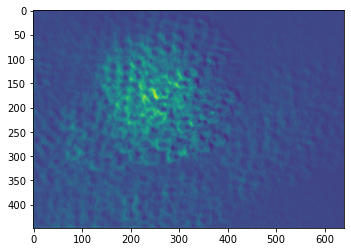

In [24]:
test=_onenet.predict(input_batch[0,:,:,0].numpy().reshape((1,448, 640,1)))
plt.imshow(test[-2][0,:,:,0])

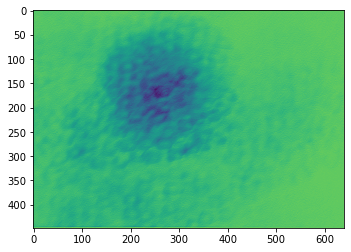

In [25]:
plt.imshow(test[-1][0,:,:,0])

In [26]:
def loss_fullmodel(model,x_test,input_tgts_placeholder):
    
    predictions_resized=model(x_test)
    
    
    
    d_l1_resized = tf.reduce_mean(tf.abs(predictions_resized - input_tgts_placeholder)) 
    ssim = tf.image.ssim_multiscale(predictions_resized, input_tgts_placeholder, 1.0)
    d_ssim_resized = 0.5 * (1 - tf.reduce_mean(ssim))
    
    
    loss = (d_l1_resized + d_ssim_resized)

    return loss

def loss_fullmodel2(model,x_test,input_tgts_placeholder):
    
    
    y_output=model(x_test)
    predictions_resized_l1=y_output[0]

    predictions_resized=y_output[1]
    
    d_l1_resized_l1 = tf.reduce_mean(tf.abs(predictions_resized_l1 - input_tgts_placeholder)) 
    ssim_l1 = tf.image.ssim_multiscale(predictions_resized_l1, input_tgts_placeholder, 1.0)
    d_ssim_resized_l1 = 0.5 * (1 - tf.reduce_mean(ssim_l1))
    
    d_l1_resized = tf.reduce_mean(tf.abs(predictions_resized - input_tgts_placeholder)) 
    ssim = tf.image.ssim_multiscale(predictions_resized, input_tgts_placeholder, 1.0)
    d_ssim_resized = 0.5 * (1 - tf.reduce_mean(ssim))
    
    
    loss = (d_l1_resized + d_ssim_resized+d_l1_resized_l1 + d_ssim_resized_l1)

    return loss

def grad(model, myloss,inputs, targets):
    with tf.GradientTape() as tape:
        loss_value = myloss(model, inputs, targets)
    return loss_value, tape.gradient(loss_value, model.trainable_variables)

In [27]:
# test=_onenet(sim.reshape((1,448, 640,1)))
# plt.imshow(test[0,:,:,0])

In [28]:
## Training with TF.Dataset
## Note: Rerunning this cell uses the same model variables
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4) #1e-3 diverges

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []
validtate_loss_results=[]
num_epochs = 1000

learning_rate_counter=0
for epoch in range(num_epochs):
    validation_loss_avg=tf.keras.metrics.Mean()
    epoch_loss_avg = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.MeanSquaredError()

    # Training loop
    iter_num=0
    for x, y in train_ds:
        #update learning rate
        lr_decay_ratio = pow(0.5, (learning_rate_counter-1)*1 / 30000.0)
        learning_rate=( 1e-4* lr_decay_ratio) 
        K.set_value(optimizer.learning_rate, learning_rate)
        learning_rate_counter=learning_rate_counter+1
        # Optimize the model
        
        loss_value, grads = grad(_onenet,loss_fullmodel2, x, y)
        optimizer.apply_gradients(zip(grads, _onenet.trainable_variables))

        # Track progress
        epoch_loss_avg.update_state(loss_value)  # Add current batch loss
        
        # Compare predicted label to actual label
        # training=True is needed only if there are layers with different
        # behavior during training versus inference (e.g. Dropout).
        
        epoch_accuracy.update_state(y, _onenet(x)[-1])
        
        # Print every 10
        if iter_num % 1 == 0:
            print("Epoch {:03d}: Step: {:03d}, Loss: {:.3f}, MSE: {:.3}".format(epoch, iter_num,epoch_loss_avg.result(),
                                                                        epoch_accuracy.result()),end='\r')
        iter_num=iter_num+1

  # End epoch
    train_loss_results.append(epoch_loss_avg.result())
    train_accuracy_results.append(epoch_accuracy.result())


    for x_val, y_val in val_ds:
        val_loss_value= loss_fullmodel2(_onenet, x_val, y_val)
        validation_loss_avg.update_state(val_loss_value)
    validtate_loss_results.append(validation_loss_avg.result())    
    if epoch % 1 == 0:
        print("Epoch {:03d}: MSE: {:.3}, Training Loss: {:.3f}, Validation Loss: {:.3f}".format(epoch,
                                                                    epoch_accuracy.result(), epoch_loss_avg.result(), 
                                                                                                validation_loss_avg.result()))

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().
Epoch 000: MSE: 0.0157, Training Loss: 0.581, Validation Loss: 0.560
Epoch 001: MSE: 0.0154, Training Loss: 0.577, Validation Loss: 0.562
Epoch 002: MSE: 0.0153, Training Loss: 0.578, Validation Loss: 0.558
Epoch 003: MSE: 0.0153, Training Loss: 0.576, Validation Loss: 0.556
Epoch 004: MSE: 0.0118, Training Loss: 0.526, Validation Loss: 0.461
Epoch 005: MSE: 0.00807, Training Loss: 0.463, Validation Loss: 0.433
Epoch 006: MSE: 0.00701, Training Loss: 0.433, Validation Loss: 0.375
Epoch 007: MSE: 0.00653, Training Loss: 0.346, Validation Loss: 0.299
Epoch 008: MSE: 0.00615, Training Loss: 0.307, Validation Loss: 0.288
Epoch 009: MSE: 0.00583, Training Loss: 0.286, Validation Loss: 0.260
Epoch 010: MSE: 0.00557, Training Loss: 0.271, Validation Loss: 0.265
Epoch 011: MSE: 0.00531, Training Loss: 0.260, Validation Loss: 0.250
Epoch 012: MSE: 0.00519, Training Loss: 0.251, 

KeyboardInterrupt: 

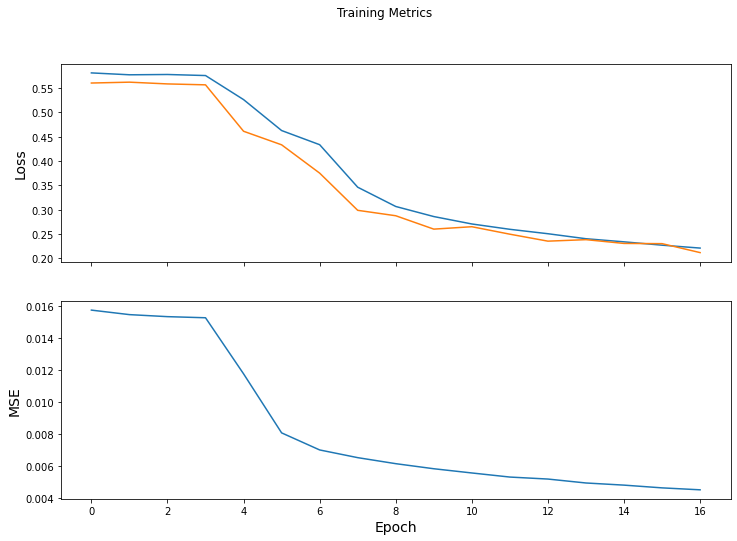

In [29]:
fig, axes = plt.subplots(2, sharex=True, figsize=(12, 8))
fig.suptitle('Training Metrics')

axes[0].set_ylabel("Loss", fontsize=14)
axes[0].plot(train_loss_results)
axes[0].plot(validtate_loss_results)

axes[1].set_ylabel("MSE", fontsize=14)
axes[1].set_xlabel("Epoch", fontsize=14)
axes[1].plot(train_accuracy_results)
plt.show()

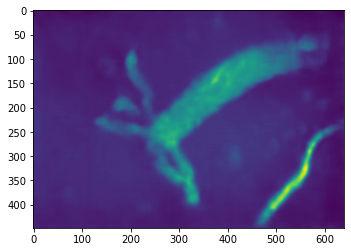

In [30]:
test=_onenet(x_val[0,:,:,0].numpy().reshape((1,448, 640,1)))
plt.imshow(test[-1][0,:,:,0])

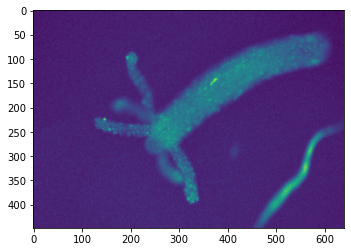

In [31]:
plt.imshow(y_val[0,:,:,0])

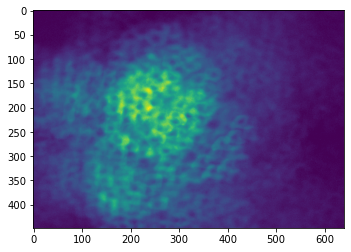

In [54]:
plt.imshow(x[0,:,:,0].numpy())

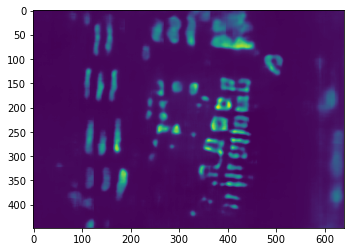

In [42]:
test=_onenet(res_target.reshape((1,448, 640,1)))
plt.imshow(test[0,:,:,0])

In [32]:
restarget=hdf5storage.loadmat('C:\Research\RandoscopePSFS\\res_15_z30.mat') 
restarget=restarget['res_15_z30']
restarget=restarget/np.max(restarget)
res_target=np.maximum(restarget,0)
res_target=res_target[18:466,4:644]

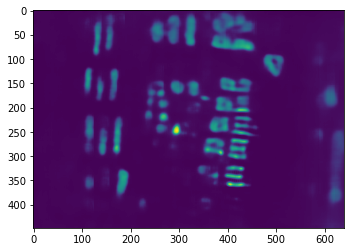

In [33]:
test=_onenet(res_target.reshape((1,448, 640,1)))
plt.imshow(test[-1][0,:,:,0])

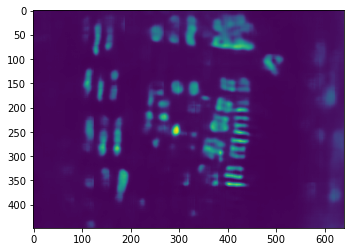

In [34]:
plt.imshow(test[-2][0,:,:,0])

In [57]:
#_onenet.save('oneUnet_resnet_50epoch') 

INFO:tensorflow:Assets written to: oneUnet_resnet_50epoch\assets


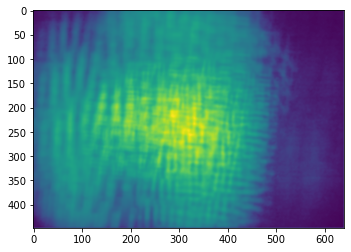

In [30]:
test=_onenet(res_target.reshape((1,448, 640,1)))
plt.imshow(test[-1][0,:,:,0])

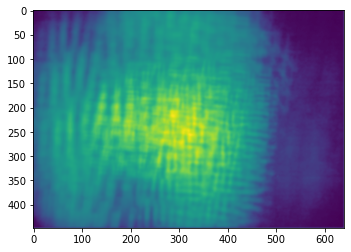

In [31]:
plt.imshow(test[-2][0,:,:,0])